In [2]:
#from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Lambda
from keras import backend as K
import cv2, numpy as np
import glob
from keras.activations import relu 
import keras as keras
from keras.models import Model


from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
img_width, img_height = 640, 480
import os
from scipy.misc import imsave
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from  sklearn.model_selection import train_test_split

#from tensorflow.python import debug as tf_debug
import imageio
import glob
from skimage import transform as tf

from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.image as plt_img
import scipy
import scipy
import skimage
import re
#import LRFinder
import math as m

from keras_contrib.losses import DSSIMObjective
from keras import backend as K
from pathlib import Path


import numpy as np
from keras_contrib.losses import DSSIMObjective
from keras import backend as K
from skimage.measure import compare_ssim, compare_psnr

import cv2
import numpy as np
from matplotlib import pyplot as plt

/home/sachin/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Preprocessing and generators

In [3]:
# Using matplotlib read and skimage resize
def get_image(path):
    return np.expand_dims(plt.imread(path[0]), axis = 0)

def get_image_array_with_glob(path):
    return np.asarray([np.array(plt.imread(file)) for file in glob.glob(path+'/'+'*.png')])

In [4]:
def train_generator(train_path, label_path, batch_size):
    L = len(train_path)

    #this line is just to make the generator infinite, keras needs that    
    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X = get_image(train_path[batch_start:limit])
            #print train_path[batch_start:limit]
            # Modify this to find similar labeled names in label directory
            
            Y = map(lambda x:(re.sub(".*/","",x)), train_path[batch_start:limit])
            Y = map(lambda x:(re.sub("_.*.png",".png",x)), Y)
            Y = map(lambda x:(re.sub("^",train_label_dir + '/',x)), Y)
            
            # Label path is redundant can be removed later
            Y = get_image(Y)
        
            #print batch_start
            #print batch_start, limit,  batch_end, "sachin", train_path[batch_start:limit]
            
            batch_start += batch_size   
            batch_end += batch_size
            
            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     


### Model definition

In [5]:
def get_unet(arg1, trainable = True):
    inputs = Input(shape=(None,None, 3))
    conv1 = Conv2D(3, (1, 1), kernel_initializer='random_normal', activation='relu', trainable = trainable)(inputs)

    conv2 = Conv2D(3, (3, 3), kernel_initializer='random_normal', activation='relu',  padding='same', trainable = trainable)(conv1)

    concat1 = concatenate([conv1, conv2], axis=-1)

    conv3 = Conv2D(3, (5, 5), activation='relu', kernel_initializer='truncated_normal', padding='same', trainable = trainable)(concat1)

    concat2 = concatenate([conv2, conv3], axis=-1)

    conv4 = Conv2D(3, (7, 7), activation='relu', kernel_initializer='random_normal', padding='same', trainable = trainable)(concat2)

    concat3 = concatenate([conv1, conv2, conv3, conv4], axis=-1)

    K = Conv2D(3, (3, 3), activation='relu', kernel_initializer='truncated_normal', padding='same', trainable = True)(concat3)

    print inputs.shape,K.shape
    product= keras.layers.Multiply()([K, inputs])
    sum1 = keras.layers.Subtract()([product, K])
    sum2 = Lambda(lambda x: 1+x) (sum1)
    #sum2 = keras.layers.Add()([sum1, ones_tensor])
    out_layer = Lambda(lambda x: relu(x)) (sum2)
    ##out_layer = relu(sum2)#


    if arg1 == 1:
        model = Model(inputs=inputs,outputs=out_layer)
    else:
        model = Model(inputs=inputs,outputs=conv1)

    return model

### Main code

In [6]:
if __name__ == '__main__':
    
    # Small set
    #train_data_dir = 'train_data/haze'
#     # Small set clear images
    #train_label_dir = 'train_data/clear'
    train_data_dir = '../../TAMU/CSCE_633/Project/half_set/haze/'
    train_label_dir = '../../TAMU/CSCE_633/Project/half_set/clear/'
    
    #train_data_dir = '../../TAMU/CSCE_633/Project/ITS/train'
    #train_label_dir = '../../TAMU/CSCE_633/Project/ITS/clear'
    
    
    #train_data_dir = '../../TAMU/CSCE_633/Project/OTS/train'
    #train_label_dir = '../../TAMU/CSCE_633/Project/OTS/clear'

    batch_size = 1
    
    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_height, img_width)
    else:
        input_shape = (img_height, img_width, 3)

In [7]:
    model_checkpoint = ModelCheckpoint('aod_net.h5', 
                                       #monitor='val_loss', 
                                       #save_best_only=True,
                                      )
    
    tensorboard_vis = TensorBoard(log_dir='./logs', histogram_freq=0, 
                                  batch_size=batch_size, write_graph=True, 
                                  write_grads=False, write_images=False, 
                                  embeddings_freq=0, embeddings_layer_names=None, 
                                  embeddings_metadata=None)
    
    
    from keras import optimizers
    # Todo: check with lr 0.001
    #rms = optimizers.RMSprop(lr=0.005, decay=0.1)
    rms = optimizers.RMSprop(lr=0.001, decay=0.0001, rho=0.9, 
                             #clipvalue=0.1,
                            )
#     rms = optimizers.Adagrad(
#                             lr=0.006, 
#                             decay=0.1
#     )
   # rms = optimizers.RMSprop()
    
    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    
#     def dice_coef(y_true, y_pred, smooth=1):
#         y_true_f = K.flatten(y_true)
#         y_pred_f = K.flatten(y_pred)
#         intersection = K.sum(y_true_f * y_pred_f)
#         return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#     #def dice_coef(y_true, y_pred, smooth=1):
# #         intersection = K.sum(y_true * y_pred, axis=[1,2,3])
# #         union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
# #         return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

#     def dice_coef_loss(y_true, y_pred):
#         return -dice_coef(y_true, y_pred)
    
    
    model = get_unet(1, False) 

   # print(model.summary())
    model.compile(loss='mean_squared_error',
                  optimizer=rms,
                  metrics=['accuracy'])
#     model.compile(loss=dice_coef_loss,
#                   optimizer=rms,
#                   metrics=[dice_coef])

------------------------------
Fitting model...
------------------------------
(?, ?, ?, 3) (?, ?, ?, 3)


In [8]:
epochs = 1


train_path = glob.glob(train_data_dir+'/'+'*.png')
label_path = glob.glob(train_label_dir+'/'+'*.png')

train_X, validation_X = train_test_split(train_path, test_size=0.0, 
                                         shuffle=True,
                                         #random_state=1,
                                        )
steps_per_epoch = int(len(train_X)/batch_size)


train_set_size = len(train_path)
print "Train set size is:", train_set_size, ",", "Steps per epochs is:", steps_per_epoch, ",", "batch size is:", batch_size, "total epochs is:", epochs
#assert (train_set_size == (steps_per_epoch*batch_size))
assert (train_set_size == (len(glob.glob(train_label_dir+'/'+'*.png'))))



validation_steps = int(len(validation_X)/batch_size)
print "Validation steps:", validation_steps                                        

                                        
#print validation_X, len(validation_X)

Train set size is: 6500 , Steps per epochs is: 6500 , batch size is: 1 total epochs is: 1
Validation steps: 0


In [9]:
model.load_weights('aod.h5')
model.save('aod_1_epoch_weights.h5')

In [9]:
model.fit_generator(generator=train_generator(train_X, label_path, batch_size),
                    #validation_data=generate_arrays_from_file(validation_X, label_path, batch_size),
                    steps_per_epoch=steps_per_epoch, 
                    #validation_steps = validation_steps,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[model_checkpoint, tensorboard_vis],
                    #use_multiprocessing=False,
                    #max_queue_size = False,
                    )

Epoch 1/1
 277/6500 [>.............................] - ETA: 10:17 - loss: 0.0259 - acc: 0.9358

/home/sachin/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102988). Check your callbacks.
  % delta_t_median)


4669/6500 [====================>.........] - ETA: 2:46 - loss: 0.0255 - acc: 0.9317- ETA: 2:55 -  - ETA: 2:48 - loss: 0.02 - ETA: 2:46 - loss: 0.0256 - acc:

/home/sachin/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143095). Check your callbacks.
  % delta_t_median)


4672/6500 [====================>.........] - ETA: 2:46 - loss: 0.0255 - acc: 0.931

/home/sachin/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111317). Check your callbacks.
  % delta_t_median)


4801/6500 [=====================>........] - ETA: 2:35 - loss: 0.0255 - acc: 0.9319- ETA: 2:39 - loss: 0.0255 - acc: - ETA: 2:38 - loss:  - ETA: 2:36 - loss: 0.02

/home/sachin/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130918). Check your callbacks.
  % delta_t_median)


4878/6500 [=====================>........] - ETA: 2:30 - loss: 0.0255 - acc: 0.9319- ETA: 2:33 - loss: 0.0255 - acc: 0. - E

/home/sachin/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208027). Check your callbacks.
  % delta_t_median)


4881/6500 [=====================>........] - ETA: 2:29 - loss: 0.0255 - acc: 0.9319- ETA: 2:30 - loss: 0.0255 - acc: 0.931

/home/sachin/anaconda2/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115872). Check your callbacks.
  % delta_t_median)


6500/6500 [==============================] - 592s 91ms/step - loss: 0.0252 - acc: 0.9314 - ETA:  - ETA: 1s - loss: 0.025


## Test for RTTS i.e. code to just produce dehazed images.

In [10]:
# Small test set
test_data_dir = glob.glob('/home/sachin/Machine_Learning_Projects/keras-retinanet/RTTS/JPEGImages_DCP_0.5512/' + '/'+'*.png')
test_data_dir = glob.glob('/home/sachin/Machine_Learning_Projects/dark-channel-prior-dehazing/img/' + '/'+'*.png')
#test_data_dir = glob.glob('/media/sachin/DATA/TAMU/CSCE_633/Project/RTTS/JPEGImages/BD_Baidu_322.png')
#test_data_dir = glob.glob('test_data/haze2' +'/'+'*.png')
print test_data_dir

# SOTS dataset testing

['/home/sachin/Machine_Learning_Projects/dark-channel-prior-dehazing/img/FogDr_Bing_635_clahe.png', '/home/sachin/Machine_Learning_Projects/dark-channel-prior-dehazing/img/hv17_48_clahe.png', '/home/sachin/Machine_Learning_Projects/dark-channel-prior-dehazing/img/HazeDr_Google_767_clahe.png', '/home/sachin/Machine_Learning_Projects/dark-channel-prior-dehazing/img/BJ_Google_620_clahe.png', '/home/sachin/Machine_Learning_Projects/dark-channel-prior-dehazing/img/hv37_115_clahe.png', '/home/sachin/Machine_Learning_Projects/dark-channel-prior-dehazing/img/HazeDr_Google_787_clahe.png', '/home/sachin/Machine_Learning_Projects/dark-channel-prior-dehazing/img/hv3_91_clahe.png', '/home/sachin/Machine_Learning_Projects/dark-channel-prior-dehazing/img/XR_Baidu_460_clahe.png', '/home/sachin/Machine_Learning_Projects/dark-channel-prior-dehazing/img/SJZ_Google_123_clahe.png', '/home/sachin/Machine_Learning_Projects/dark-channel-prior-dehazing/img/HEB_Baidu_610_clahe.png', '/home/sachin/Machine_Learni

In [ ]:
model = load_model('aod_net.h5',
                  custom_objects={
                      #'sum2':sum2,
                      'relu':relu,
                      #'range_error':range_error,
                      #'heat_error':heat_error,
                  }
                  )

In [35]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [11]:
test_pred_dir = 'dehazed_clahe_wo_dcp'

def save_image(Y_predicted_array, filenames):
    #print filenames
    if not os.path.exists(test_pred_dir):
          os.mkdir(test_pred_dir)
    for idx, file_name in enumerate(filenames):
        f = re.sub(".png","", file_name)
        f = re.sub(".*/","", f)
        #print  Y_predicted_array[idx].shape
        scipy.misc.toimage(Y_predicted_array[idx]).save(os.path.join(test_pred_dir, f + "_dehazed.png"))
        #plt_img.imsave(os.path.join(pred_dir, f + "_dehazed.png"), Y_predicted_array[idx], format = 'png')

In [12]:
def show_image(file_data):
    plt.figure(figsize=(20, 6))
    plt.imshow(file_data)
    plt.show()

## Run this to produce dehazed images

Steps: 4322 Length of test set: 4322
1/1 [==============================] - 1s 729ms/step


/home/sachin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  # This is added back by InteractiveShellApp.init_path()


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 215ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 207ms/step


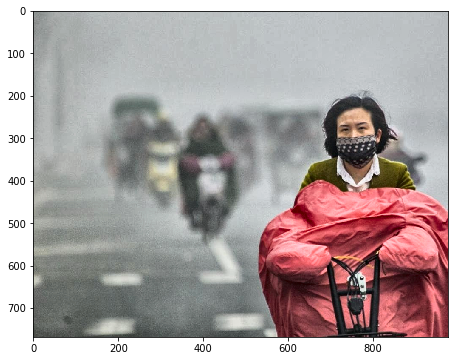

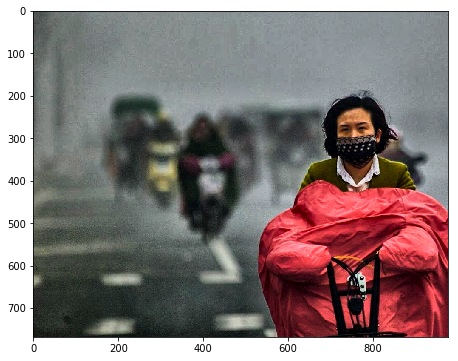

In [13]:
    batch_size = 1
    assert batch_size == 1
    steps = int(m.ceil(len(test_data_dir)/float(batch_size)))
    print "Steps:", steps, "Length of test set:", len(test_data_dir)
    assert (steps*batch_size >= len(test_data_dir))
    
    for step_idx in range(0,steps):
        
        Y_array = get_image(test_data_dir[step_idx*batch_size:(step_idx+1)*batch_size])
        #print test_data_dir[step_idx*batch_size:(step_idx+1)*batch_size]
        Y_predicted_array = model.predict(Y_array, batch_size=batch_size, verbose=1)
    
        #print Y_predicted_array.shape
        save_image(Y_predicted_array, test_data_dir[step_idx*batch_size:(step_idx+1)*batch_size])
    #show_image(X_test[0]) 
    
    show_image(Y_array[0])
    show_image(Y_predicted_array[0])

## Testing on the SOTS dataset

### Predict phase and SSIM and PSNR computation . If you want to predict, run from here

In [1]:
# Small test set
test_data_dir = 'test_data/haze2'
test_label_dir = 'test_data/clear'


# SOTS testing
test_data_dir = '/media/sachin/01D36809EE3B89B0/RESIDE/SOTS/combined/hazy/'
test_label_dir = '/media/sachin/01D36809EE3B89B0/RESIDE/SOTS/combined/clear/'
test_pred_dir = '/media/sachin/01D36809EE3B89B0/RESIDE/SOTS/combined/dehazed/'
# Pyramid dehazing
test_pred_dir = '/media/sachin/01D36809EE3B89B0/RESIDE/SOTS/combined/dehazed2/'

(413, 550, 3)
(774,)
(413, 550, 3)
(542,)


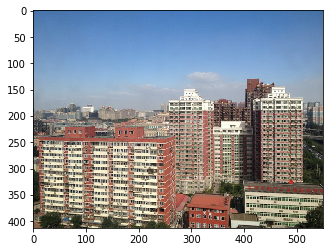

Steps: 774 Length of test set: 774
1/1 [==============================] - 0s 17ms/step


/home/sachin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  # This is added back by InteractiveShellApp.init_path()


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 9ms/step


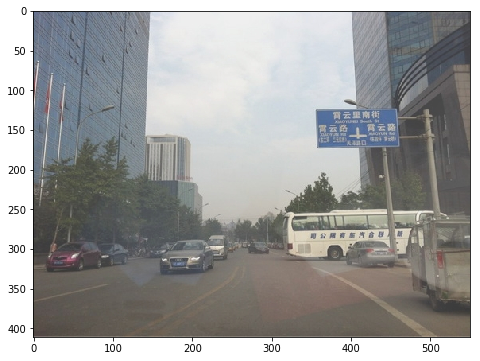

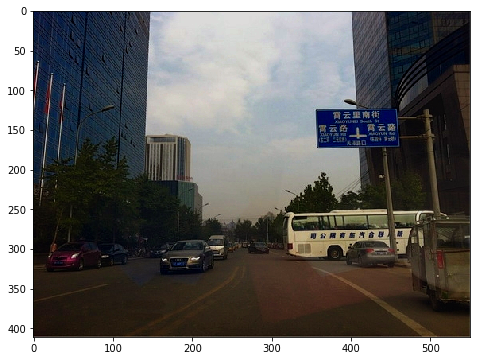

In [17]:
X_test, Y_test = get_image_array_with_glob(test_data_dir), get_image_array_with_glob(test_label_dir)
#     print(X_train[0].shape)
#     print(X_train.shape)

#     print(Y_train[0].shape)
#     print(Y_train.shape)

print(X_test[0].shape)
print(X_test.shape)

print(Y_test[0].shape)
print(Y_test.shape)

#plt.imshow(cv2.cvtColor(X_test[0], cv2.COLOR_BGR2RGB))
plt.imshow(X_test[0])
plt.imshow(Y_test[0])

plt.show()

test_data_dir = glob.glob(test_data_dir+'/'+'*.png')
#test = glob.glob(test_label_dir +'/'+'*.png')

# Generating the predicted images for the test array
batch_size = 1
assert batch_size == 1
steps = int(m.ceil(len(test_data_dir)/float(batch_size)))
print "Steps:", steps, "Length of test set:", len(test_data_dir)
assert (steps*batch_size >= len(test_data_dir))

for step_idx in range(0,steps):
    #print "sachin", test_data_dir[step_idx*batch_size:(step_idx+1)*batch_size]
    Y_array = get_image(test_data_dir[step_idx*batch_size:(step_idx+1)*batch_size])
    #print test_data_dir[step_idx*batch_size:(step_idx+1)*batch_size]
    Y_predicted_array = model.predict(Y_array, batch_size=batch_size, verbose=1)

    #print Y_predicted_array.shape
    save_image(Y_predicted_array, test_data_dir[step_idx*batch_size:(step_idx+1)*batch_size])
#show_image(X_test[0]) 

show_image(Y_array[0])
show_image(Y_predicted_array[0])

In [7]:
test_data_dir = glob.glob(test_data_dir+'/'+'*.png')
print len(test_data_dir)

774


In [8]:
# SSIM computation
# List of processed images for Debug
processed_list = []
image_count = 0
ssim_array = np.array([])
psnr_array = np.array([])
for file_name in test_data_dir:
    f_pred = re.sub(".png","", file_name)
    f_pred = re.sub(".*/","", f_pred)
    f_pred = os.path.join(test_pred_dir, f_pred + "_dehazed.png")
    processed_list.append(f_pred)
    #print f_pred
    
    f_true = re.sub(".*/", "", file_name)
    f_true = re.sub("_.*.png", ".png", f_true)
    #print f_true
    
    f_true = test_label_dir + "/" + f_true
    
    #print f_true
    if ((Path(f_pred).is_file()) and (Path(f_true).is_file())):
        img_pred = skimage.transform.resize(np.array(plt.imread(f_pred)), (img_height,img_width),  mode='constant')
        img_true = skimage.transform.resize(np.array(plt.imread(f_true)), (img_height,img_width),  mode='constant')
        ssim_array = np.append(ssim_array, np.array([compare_ssim(img_pred, img_true, multichannel=True)]))
        psnr_array = np.append(psnr_array, np.array([compare_psnr(img_true, img_pred)]))
        
print "Average SSIM of True vs Predicted images: " , np.average(ssim_array)
print "Average PSNR of True vs Predicted images: " , np.average(psnr_array)

#print ssim_array

Average SSIM of True vs Predicted images:  0.8938647382556523
Average PSNR of True vs Predicted images:  18.84078908166019


## Edge detection and enhancement

In [ ]:

img = cv2.imread('/media/sachin/DATA/TAMU/CSCE_633/Project/RTTS/JPEGImages/BD_Baidu_322.png',0)
# img = get_image(['/media/sachin/DATA/TAMU/CSCE_633/Project/RTTS/JPEGImages/BD_Baidu_322.png'])
# img = img*255
# print img.shape
edges = cv2.Canny(img,100,100)
print edges.shape
print img, edges

plt.subplot(121),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges)
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

## CLAHE

In [24]:
test_data_dir = glob.glob('/media/sachin/DATA/TAMU/CSCE_633/Project/RTTS/JPEGImages/' + '/'+'*.png')
#test_data_dir = ['/media/sachin/DATA/TAMU/CSCE_633/Project/RTTS/JPEGImages/BD_Baidu_322.png']


In [25]:
test_pred_dir = 'clahe'

def save_image(Y_predicted_array, filename):
    #print filenames
    if not os.path.exists(test_pred_dir):
          os.mkdir(test_pred_dir)
    #for idx, file_name in enumerate(filenames):
    f = re.sub(".png","", filename)
    f = re.sub(".*/","", f)
    #print  Y_predicted_array[idx].shape
    cv2.imwrite(os.path.join(test_pred_dir, f + "_clahe.png"), Y_predicted_array)
    #scipy.misc.toimage(Y_predicted_array[idx]).save(os.path.join(test_pred_dir, f + "_clahe.png"))
    #plt_img.imsave(os.path.join(pred_dir, f + "_dehazed.png"), Y_predicted_array[idx], format = 'png')


for item in test_data_dir:
    bgr = cv2.imread(item)
    #plt.imshow(bgr)
    #plt.show()
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)

    lab_planes = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0,
                            tileGridSize=(7,7)
                           )

    lab_planes[0] = clahe.apply(lab_planes[0])

    lab = cv2.merge(lab_planes)

    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    save_image(bgr, item)
    #plt.imshow(bgr)
    #plt.show()
    
    